<a href="https://colab.research.google.com/github/wagner1986/PapyrusTech/blob/main/LocalFeatureMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install kornia
!pip install kornia_moons

In [48]:
import torch
import torch.nn as nn
import torchvision
import kornia as K

class PreprocessPipeline(nn.Module):
    def __init__(self):
        super(PreprocessPipeline, self).__init__()
        self.transforms = nn.Sequential(
            # Normaliza a imagem para ter valores no intervalo [0, 1]
            K.enhance.Normalize(0.0, 255.0),
            # Redimensiona a imagem para o tamanho desejado
            K.geometry.Resize((200, 200)),
            # Converte a imagem RGB para escala de cinza
            K.color.RgbToGrayscale(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza a imagem para ter valores no intervalo [0, 1]
        x = x.float() / 255.0  # Garante que a operação de divisão é realizada em float
        # Aplica as transformações definidas em __init__
        x = self.transforms(x)
        # Adiciona uma dimensão de batch no início se ainda não houver
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return x

# Inicializa o pipeline de preprocessamento
preprocess = PreprocessPipeline()


In [49]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from scipy.spatial import Delaunay

INF = np.inf

# Calcula a distância Euclidiana entre dois pontos p1 e p2
def distancePoint(p1, p2):
    ax, ay = p1[0], p1[1]
    bx, by = p2[0], p2[1]
    dist = math.hypot(ax - bx, ay - by)
    return dist

# Aplica o algoritmo de Floyd-Warshall para encontrar as menores distâncias entre todos os pares de vértices
def floydWarshall(graph):
    graph = csr_matrix(graph)
    dist_matrix, predecessors = floyd_warshall(csgraph=graph, directed=False, return_predecessors=True)
    return dist_matrix

# Constrói a matriz de adjacência do grafo baseado em conexões entre pontos
def buildMapGraph(mapConex, mapPoint):
    size = len(mapPoint)
    sample = np.matrix(np.ones((size, size)) * np.inf)
    for i in range(size):
        sample[i, i] = 0  # Distância de um ponto para si mesmo é 0
    for conexao in mapConex:
        distance = distancePoint(mapPoint[conexao[0]], mapPoint[conexao[1]])
        sample[conexao[0], conexao[1]] = distance
    return sample

# Constrói conexões baseadas nos simplices da triangulação de Delaunay
def buildConnection(tri):
    mapConnection = []
    for simplice in tri.simplices:
        # Cada simplex representa um triângulo; adicione as arestas do triângulo ao grafo
        mapConnection.append([simplice[0], simplice[1]])
        mapConnection.append([simplice[1], simplice[2]])
        mapConnection.append([simplice[2], simplice[0]])
    return mapConnection

# Plota os pontos, a triangulação de Delaunay e os índices dos pontos
def plot_delaunay(points, tri,img):
    plt.imshow(img)
    plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy(),color='orange')
    plt.plot(points[:, 0], points[:, 1], 'o')

    dist =3
    # Loop para adicionar os índices dos pontos
    for i, point in enumerate(points):
        plt.text(point[0]+dist, point[1]+dist, f' {i}', color='red', fontsize=12)

    plt.show()

# Função extract_graph modificada para aceitar e utilizar featuresByPoints
def extract_graph(points, featuresByPoints):
    tri = Delaunay(points)
    mapConnection = buildConnection(tri)
    # Passa featuresByPoints para buildMapGraph para calcular as distâncias baseadas em características
    sample = buildMapGraph(mapConnection, featuresByPoints)
    graphCalc = floydWarshall(sample)
    return graphCalc, points, tri

# Compara duas matrizes de distância e conta os elementos cuja diferença é menor que um limiar
def match_matrix(mat_a, mat_b, threshold=0.2):
    mat_dist = mat_b - mat_a
    for i in range(mat_dist.shape[0]):
        mat_dist[i, :i] = 0  # Zera a metade inferior da matriz para evitar duplicação
    mat_dist = mat_dist * mat_dist  # Eleva as diferenças ao quadrado
    points = 0
    for i in range(mat_dist.shape[0]):
        for j in range(i + 1, mat_dist.shape[0]):
            if mat_dist[i, j] < threshold:  # Utiliza o limiar parametrizável
                points += 1
    return points

In [53]:
class CustomLocalFeatureMatcher:
    def __init__(self, feature_extractor, descriptor_matcher):
        self.feature_extractor = feature_extractor
        self.descriptor_matcher = descriptor_matcher

    def __call__(self, input):
        image0, image1 = input["image0"], input["image1"]

        # Extrair pontos-chave e descritores
        lafs0,x0, descriptors0 = self.feature_extractor(image0)
        lafs1,x1, descriptors1 = self.feature_extractor(image1)

        distance,matches = self.descriptor_matcher(descriptors0[0],descriptors1[0])
        keypoints0 = lafs0[0,:, :, 2].data
        keypoints1 = lafs1[0,:, :, 2].data

        # Retorna os keypoints, descritores e correspondências
        return {
            "keypoints0": keypoints0,
            "keypoints1": keypoints1,
            "lafs0": lafs0,
            "lafs1": lafs1,
            "descriptors0": descriptors0[0],
            "descriptors1": descriptors1[0],
            "matches": matches
        }


torch.Size([25, 2]) <class 'torch.Tensor'> torch.Size([1, 25, 2, 3]) <class 'torch.Tensor'> torch.Size([25, 128]) <class 'torch.Tensor'> torch.Size([7, 2])


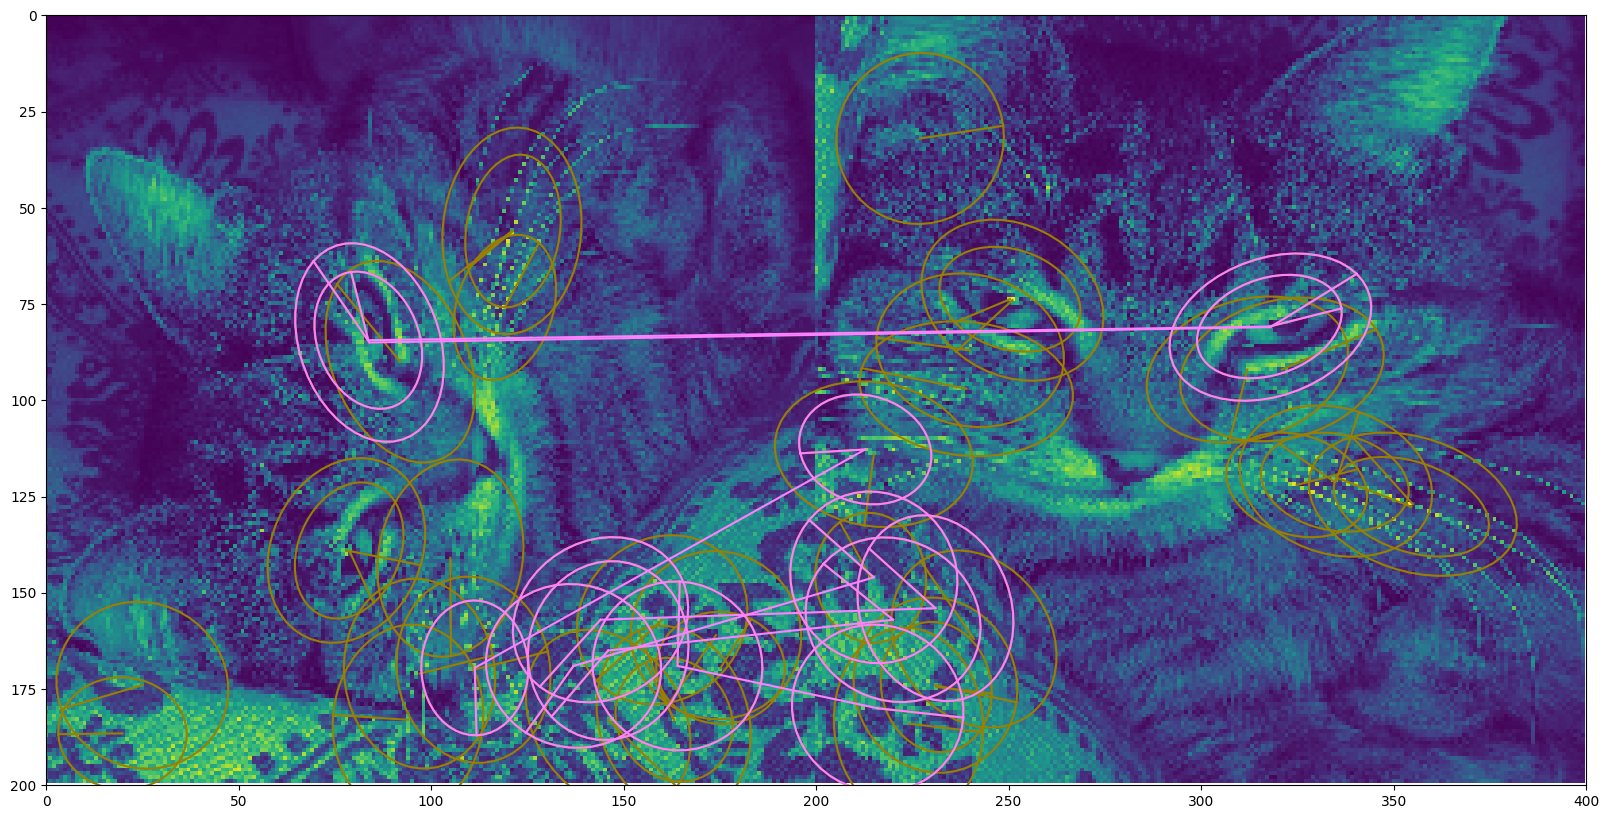

In [54]:
from kornia.feature import LocalFeatureMatcher,GFTTAffNetHardNet
from kornia_moons.viz import draw_LAF_matches

# Carregar as duas imagens utilizando torchvision
img1 = torchvision.io.read_image("image1.jpg").float() / 255.0
img2 = torchvision.io.read_image("image2.jpg").float() / 255.0

# Aplica o pipeline de preprocessamento à imagem
img1_preprocessed = preprocess(img1)
# Aplica o pipeline de preprocessamento à imagem
img2_preprocessed = preprocess(img2)


input = {"image0": img1_preprocessed, "image1": img2_preprocessed}

customFeatureMatcher = CustomLocalFeatureMatcher(
    GFTTAffNetHardNet(25), K.feature.DescriptorMatcher('smnn', 0.85)
)
out2 = customFeatureMatcher(input)

print(out2['keypoints1'].shape,type(out2['keypoints1']),
      out2['lafs1'].shape,type(out2['lafs1']),
      out2['descriptors1'].shape,type(out2['descriptors1']),
      out2['matches'].shape,)


# Agora, desenhe os matchings
draw_LAF_matches(
    out2['lafs0'],
    out2['lafs1'],
    out2['matches'],
    K.tensor_to_image(img1_preprocessed.squeeze()),  # Garante que as imagens estão sem a dimensão de batch
    K.tensor_to_image(img2_preprocessed.squeeze()),
    None,  # Ou None se você não tiver uma máscara de inliers
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1.0, 0.5, 1),
        "feature_color": (0.6, 0.5, 0),
        "vertical": False,
    },
)

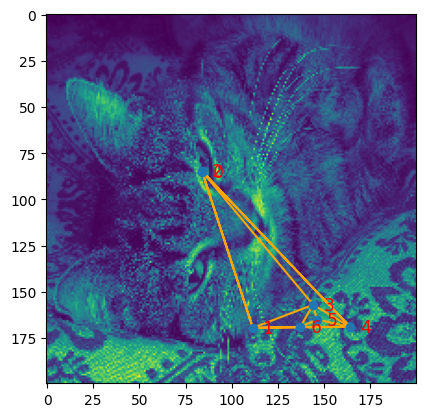

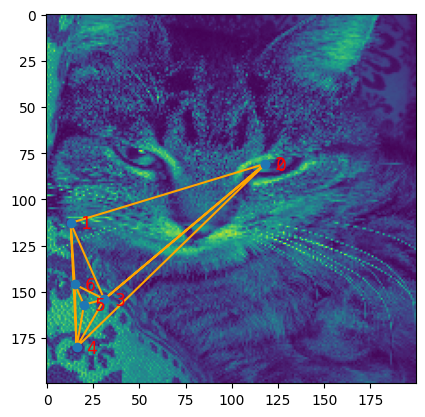

(7, 7) <class 'numpy.ndarray'> (7, 7) <class 'numpy.ndarray'>
[[0.         0.04434298 0.0482534  0.08895101 0.1905001  0.29620883
  0.19754197]
 [0.04434298 0.         0.09022605 0.12174676 0.19705298 0.32029702
  0.219204  ]
 [0.0482534  0.09022605 0.         0.13720441 0.21474358 0.33798761
  0.24579537]
 [0.08895101 0.12174676 0.13720441 0.         0.13071767 0.20725782
  0.10859096]
 [0.1905001  0.19705298 0.21474358 0.13071767 0.         0.12324404
  0.20024447]
 [0.29620883 0.32029702 0.33798761 0.20725782 0.12324404 0.
  0.21511529]
 [0.19754197 0.219204   0.24579537 0.10859096 0.20024447 0.21511529
  0.        ]] [[0.         0.15601437 0.12721704 0.21159207 0.09564498 0.28287005
  0.29860374]
 [0.15601437 0.         0.15998615 0.26948982 0.06036939 0.24759446
  0.22566219]
 [0.12721704 0.15998615 0.         0.11861666 0.22035554 0.30853234
  0.21162126]
 [0.21159207 0.26948982 0.11861666 0.         0.227775   0.18991568
  0.09300461]
 [0.09564498 0.06036939 0.22035554 0.227775

In [52]:
pts0=out2['keypoints0'][out2['matches'][:, 0]].detach().numpy()
desc0=out2['descriptors0'][out2['matches'][:, 0]].detach().numpy()
# Extrai o grafo, calcula as distâncias mínimas e obtém a triangulação de Delaunay
dist_matrix0, new_points0, tri0 = extract_graph(pts0,desc0)
# Plota a triangulação de Delaunay
plot_delaunay(new_points0, tri0,K.tensor_to_image(img1_preprocessed.squeeze()))

pts1= out2['keypoints1'][out2['matches'][:, 1]].detach().numpy()
desc1=out2['descriptors1'][out2['matches'][:, 1]].detach().numpy()
# Extrai o grafo, calcula as distâncias mínimas e obtém a triangulação de Delaunay
dist_matrix1, new_points1, tri1 = extract_graph(pts1,desc1)
# Plota a triangulação de Delaunay
plot_delaunay(new_points1, tri1,K.tensor_to_image(img2_preprocessed.squeeze()))

# Compara as matrizes de distância dos dois grafos
matching_points = match_matrix(dist_matrix0, dist_matrix1,threshold=0.01)
print(dist_matrix0.shape,type(dist_matrix0),
      dist_matrix1.shape,type(dist_matrix1))
print(dist_matrix0,
      dist_matrix1)
print(f"Matching Points: {matching_points}")
